In [0]:
CUDA_LAUNCH_BLOCKING="1"
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sede 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip install -q torch torchvision livelossplot

In [0]:
import math
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import random
import cv2
from collections import OrderedDict
from time import sleep
from livelossplot import PlotLosses

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [0]:
class normalize(object):
  def __call__(self,x):
    """
        argument
            - x: input image data in numpy array [32, 32, 3]
        return
            - normalized x 
    """
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

In [0]:
# helper function to make getting another batch of data easier
def cycle(iterable):
  while True:
      for x in iterable:
          yield x

In [0]:
def get_dataset(dataset, horse_index, plane_index):
  dataset_hp =  []
  dataset_horses = []
  dataset_planes = []
  for i in dataset:
      if i[1] == horse_index:
          dataset_horses.append(i)
          dataset_hp.append(i)
      if i[1] == plane_index:
          dataset_planes.append(i)
          dataset_hp.append(i)
  return dataset_hp, dataset_horses, dataset_planes

In [6]:
class_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

dataset_train = torchvision.datasets.CIFAR10('data', train=True, download=True, transform=torchvision.transforms.Compose([
    normalize(),                                                                                                                      
    torchvision.transforms.ToTensor()
]))

dataset_test = torchvision.datasets.CIFAR10('data', train=False, download=True, transform=torchvision.transforms.Compose([
    normalize(),
    torchvision.transforms.ToTensor()
]))

dataset = torch.utils.data.ConcatDataset((dataset_train, dataset_test))

dataset_hp, dataset_horses, dataset_planes = get_dataset(dataset, 7, 0)

train_loader = torch.utils.data.DataLoader(dataset_hp, shuffle=True, batch_size=64, drop_last=True)

train_iterator = iter(cycle(train_loader))

print(f'> Size of training dataset {len(train_loader.dataset)}')
print(f'> Number of planes: {len(dataset_planes):,}')
print(f'> Number of horses: {len(dataset_horses):,}')

Files already downloaded and verified
Files already downloaded and verified
> Size of training dataset 12000
> Number of birds: 6,000
> Number of horses: 6,000


**View some of the test dataset**

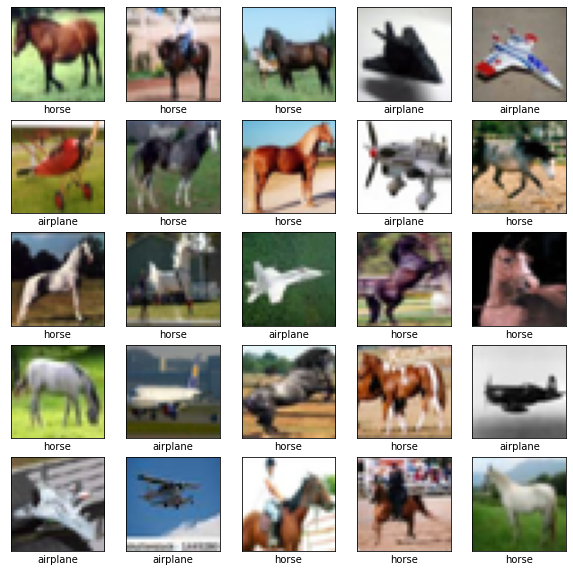

In [7]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_loader.dataset[i][0].permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
    plt.xlabel(class_names[train_loader.dataset[i][1]])

**Define the network: (1) Encoder, (2) Generator [Decoder] and (3) Discriminator**

In [0]:
class Encoder(nn.Module):
  """
    Encoder class
    Model:
      conv1: (in_channels, 32, 32) -> (64, 32, 32)
      conv2: (64, 32, 32) -> (128, 16, 16)
      conv3: (128, 16, 16) -> (256, 8, 8)
      fc1: (256 * 8 * 8) -> (2048)
      mu: (2048) -> (nz)
      logvar: (2048) -> (nz)
  """
  def __init__(self, in_channels = 3, init_features=64, nz=100):
    super(Encoder, self).__init__()

    features = init_features
    
    self.conv1 = nn.Sequential(
      nn.Conv2d(in_channels, features, kernel_size=5, stride=1, padding=2, bias=False),
      nn.BatchNorm2d(features),
      nn.ReLU(inplace=True)
    )

    self.conv2 = nn.Sequential(
      nn.Conv2d(features, features * 2, kernel_size=5, stride=2, padding=2, bias=False),
      nn.BatchNorm2d(features * 2),
      nn.ReLU(inplace=True)
    )

    self.conv3 = nn.Sequential(
      nn.Conv2d(features * 2, features * 4, kernel_size=5, stride=2, padding=2, bias=False),
      nn.BatchNorm2d(features * 4),
      nn.ReLU(inplace=True)
    )

    self.fc1 = nn.Sequential(
      nn.Linear(256 * 8 * 8, 2048, bias=False),
      nn.BatchNorm1d(2048),
      nn.ReLU(inplace=True)
    )

    self.mu = nn.Linear(2048, nz, bias = False)
    self.logvar = nn.Linear(2048, nz, bias = False)

  def reparameterize(self, mu, logvar):
    if self.training:
      std = logvar.mul(0.5).exp_()
      eps = torch.randn_like(std)
      return eps.mul(std).add_(mu)
    else:
      return mu

  def encode(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = x.view(x.size(0), -1)
    h1 = self.fc1(x)
    z_mu = self.mu(h1)
    z_var = self.logvar(h1)
    return z_mu, z_var

  def forward(self, x):
    mu, logvar = self.encode(x)
    z = self.reparameterize(mu, logvar)
    return z, mu, logvar


In [0]:
# NOTE: Decoder renamed to Generator (due to variable name clash)
class Generator(nn.Module):
  """
    Generator class
    Model:
      fc1: (nz) -> (256 * 8 * 8)
      upConv1: (256, 8, 8) -> (256, 16, 16)
      upConv2: (256, 16, 16) -> (128, 32, 32)
      upConv3: (128, 32, 32) -> (64, 32, 32)
      conv1: (64, 32, 32) -> (out_channels, 32, 32)
  """
  def __init__(self, out_channels = 3, nz=100):
    super(Generator, self).__init__()

    self.fc1 = nn.Sequential(
      nn.Linear(nz, 256 * 8 * 8, bias=False),
      nn.BatchNorm1d(256 * 8 * 8),
      nn.ReLU(inplace=True)
    )

    self.upConv1 = nn.Sequential(
      nn.ConvTranspose2d(256, 256, kernel_size=5, stride=2, padding=2, output_padding = 1, bias=False),
      nn.BatchNorm2d(256),
      nn.ReLU(inplace=True)
    )

    self.upConv2 = nn.Sequential(
      nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2, output_padding = 1, bias=False),
      nn.BatchNorm2d(128),
      nn.ReLU(inplace=True)
    )

    self.upConv3 = nn.Sequential(
      nn.Conv2d(128, 64, kernel_size=5, stride=1, padding=2, bias=False),
      nn.BatchNorm2d(64),
      nn.ReLU(inplace=True)
    )

    self.conv1 = nn.Sequential(
      nn.Conv2d(64, out_channels, kernel_size=5, stride=1, padding=2),
      nn.Tanh()
    )

  def forward(self, z):
    out = self.fc1(z)
    out = out.view(out.size(0), 256, 8, 8)
    out = self.upConv1(out)
    out = self.upConv2(out)
    out = self.upConv3(out)
    out = self.conv1(out)
    return out

In [0]:
class Discriminator(nn.Module):
  """
    Discriminator class
    Model:
      conv1: (nc, 32, 32) -> (32, 32, 32)
      conv2: (32, 32, 32) -> (128, 16, 16)
      conv3: (128, 16, 16) -> (256, 8, 8)
      conv4: (256, 8, 8) -> (256, 8, 8)
      fc1: (256*8*8) -> (512)
      fc2: (512) -> (1)
  """

  def __init__(self, f=32):

      super(Discriminator, self).__init__()
      
      self.conv1 = nn.Sequential(
          nn.Conv2d(3, 32, 5, 1, 2, bias=False),
          nn.LeakyReLU(0.2, inplace=True),  
      )

      self.conv2 = nn.Sequential(
          nn.Conv2d(32, 128, 5, 2, 2, bias=False),
          nn.BatchNorm2d(128),
          nn.LeakyReLU(0.2, inplace=True),  
      )
              
      self.conv3 = nn.Sequential(
          nn.Conv2d(128, 256, 5, 2, 2, bias=False),
          nn.BatchNorm2d(256),
          nn.LeakyReLU(0.2, inplace=True),  
      )
                      
      self.conv4 = nn.Sequential(
          nn.Conv2d(256, 256, 5, 1, 2, bias=False),
          nn.BatchNorm2d(256),
          nn.LeakyReLU(0.2, inplace=True),  
      )

      self.fc1 = nn.Sequential(
        nn.Linear(256 * 8 * 8, 512, bias=False),
        nn.BatchNorm1d(512),
        nn.ReLU(inplace=True)
      )

      self.fc2 = nn.Sequential(
        nn.Linear(512, 1),
        nn.Sigmoid()
      )

  def feature(self, x):
    f = self.conv1(x)
    f = self.conv2(f)
    f = self.conv3(f)
    return f.view(-1, 256 * 8 * 8)

  def forward(self, x):
      x = self.conv1(x)
      x = self.conv2(x)
      x = self.conv3(x)
      x = self.conv4(x)
      x = x.view(-1, 256 * 8 * 8)
      x = self.fc1(x)
      x = self.fc2(x)        
      return x

In [11]:
E = Encoder().to(device)
G = Generator().to(device)
D = Discriminator().to(device)

print(f'> Number of Encoder parameters {len(torch.nn.utils.parameters_to_vector(E.parameters()))}')
print(f'> Number of Generator parameters {len(torch.nn.utils.parameters_to_vector(G.parameters()))}')
print(f'> Number of Discriminator parameters {len(torch.nn.utils.parameters_to_vector(D.parameters()))}')

# initialise the optimiser
optimiser_E = torch.optim.Adam(E.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimiser_G = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimiser_D = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

bce_loss = nn.BCELoss()
l1_loss = nn.L1Loss()
liveplot = PlotLosses()

batch_size = 64
total_epoch = 250

> Number of Encoder parameters 34997824
> Number of Generator parameters 4339267
> Number of Discriminator parameters 10953825


**Main training loop**

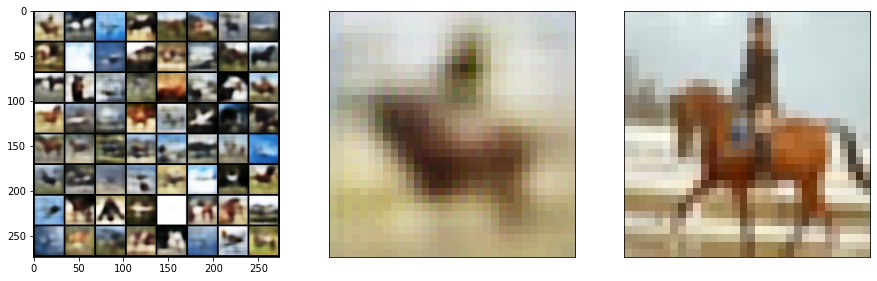

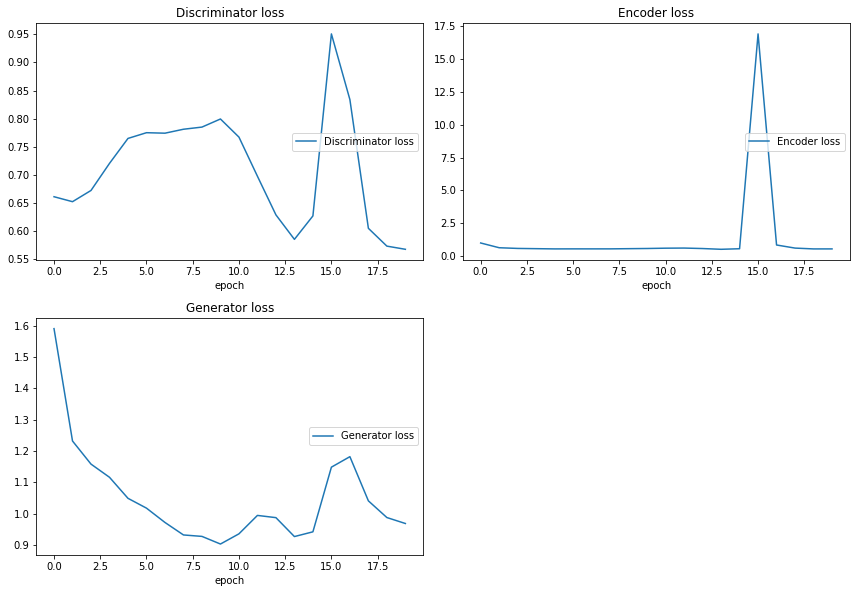

Discriminator loss
	Discriminator loss 	 (min:    0.568, max:    0.951, cur:    0.568)
Encoder loss
	Encoder loss     	 (min:    0.513, max:   16.909, cur:    0.543)
Generator loss
	Generator loss   	 (min:    0.903, max:    1.590, cur:    0.969)




In [12]:
print("Encoder in GPU: ", next(E.parameters()).is_cuda)
print("Generator in GPU: ", next(G.parameters()).is_cuda)
print("Discriminator in GPU: ", next(D.parameters()).is_cuda)

y_real = torch.ones(batch_size, 1).to(device)
y_fake = torch.zeros(batch_size, 1).to(device)

for epoch in range(total_epoch):
  
    # arrays for metrics
    enc_loss_arr = np.zeros(0)
    gen_loss_arr = np.zeros(0)
    dis_loss_arr = np.zeros(0)

    for i in range(100):

        x_real, t = next(train_iterator)
        x_real, t = x_real.to(device, dtype=torch.float), t.to(device)
  
        if x_real.shape[0] == batch_size:

            # ===================
            # Train Discriminator
            # ===================
            # get latent space vector z from real images
            z, mu, logvar = E(x_real)
            
            # Get fake images from latent space vector
            x_fake = G(z)

            # Get latent space vector from noise
            z_p = torch.randn(batch_size, 100)
            z_p = z_p.to(device)

            # Get fake images from noise
            x_p = G(z_p)

            # Compute Discriminator Loss
            y_real_loss = bce_loss(D(x_real), y_real)
            y_fake_loss = bce_loss(D(x_fake), y_fake)
            y_p_loss = bce_loss(D(x_p), y_real)
            loss_D = (y_real_loss + y_fake_loss + y_p_loss) / 3.0
            loss_D.backward(retain_graph = True)
            optimiser_D.step()


            # =============
            # Train Encoder
            # =============
            x_real, _ = next(train_iterator)
            x_real = x_real.to(device, dtype=torch.float)
            z, mu, logvar = E(x_real)
            x_fake = G(z)

            # Compute Encoder Loss
            Loss_prior = 1e-2 * (-0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp()))
            Loss_recon = 5 * l1_loss(x_fake, x_real)
            Loss_llike = l1_loss(D.feature(x_fake), D.feature(x_real))

            loss_E = Loss_prior + Loss_recon + Loss_llike
            optimiser_E.zero_grad()
            loss_E.backward()
            optimiser_E.step()


            # =========================
            # Train Generator [Decoder]
            # =========================
            x_real, _ = next(train_iterator)
            x_real = x_real.to(device, dtype=torch.float)
            z_p = torch.randn(batch_size, 100)
            z_p = z_p.to(device)
            z, mu, logvar = E(x_real)
            x_fake = G(z)
            x_p = G(z_p)

            # Compute Generator [Decoder] Loss
            y_real_loss = bce_loss(D(x_real), y_fake)
            y_fake_loss = bce_loss(D(x_fake), y_real)
            y_p_loss = bce_loss(D(x_p), y_real)
            Loss_gan_fake = (y_real_loss + y_fake_loss + y_p_loss) / 3.0

            Loss_recon = 5 * l1_loss(x_fake, x_real)
            Loss_llike = l1_loss(D.feature(x_fake), D.feature(x_real))

            loss_G = Loss_recon + Loss_llike + Loss_gan_fake
            optimiser_G.zero_grad()
            loss_G.backward()
            optimiser_G.step()
            

            # ==================
            # Log Loss to arrays
            # ==================
            enc_loss_arr = np.append(enc_loss_arr, loss_E.item())
            gen_loss_arr = np.append(gen_loss_arr, loss_G.item())
            dis_loss_arr = np.append(dis_loss_arr, loss_D.item())

            print(
            "[%d/%d][%d/%d] Loss_E: %.4f Loss_G: %.4f Loss_D: %.4f"
            % (
                epoch,
                total_epoch,
                i,
                100,
                loss_E.item(),
                loss_G.item(),
                loss_D.item()
              )
            )

    # plot some examples
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.grid(False)
    plt.imshow(torchvision.utils.make_grid(x_fake).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)

    plt.subplot(1,3,2)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_fake.cpu().data[0].permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)

    plt.subplot(1,3,3)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_real.cpu().data[0].permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)

    liveplot.update({
        'Encoder loss': enc_loss_arr.mean(),
        'Generator loss': gen_loss_arr.mean(),
        'Discriminator loss': dis_loss_arr.mean()
    })
    liveplot.draw()

    print("\n")

In [0]:
def Interpolate():

  E.eval()
  G.eval()
  D.eval()

  plt.figure(figsize=(10, 10))
  for i in range(64):

      plt.subplot(8, 8, i+1)
      plt.xticks([])
      plt.yticks([])

      # Choose one random horse and plane
      horse = random.choice(dataset_horses)[0].to(device, dtype=torch.float)
      plane = random.choice(dataset_planes)[0].to(device, dtype=torch.float)

      horse_encoded = E(horse.unsqueeze(0))[0]
      plane_encoded = E(plane.unsqueeze(0))[0]

      # Interpolate Encodings
      pegasus = G(horse_encoded * 0.7 + plane_encoded * 0.3).squeeze(0)

      pegasus = pegasus.cpu().data.permute(0, 2, 1).contiguous().permute(2, 1, 0).numpy()
      pegasus = cv2.normalize(pegasus, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

      plt.grid(False)
      plt.imshow(pegasus, cmap=plt.cm.binary,)

  plt.show()

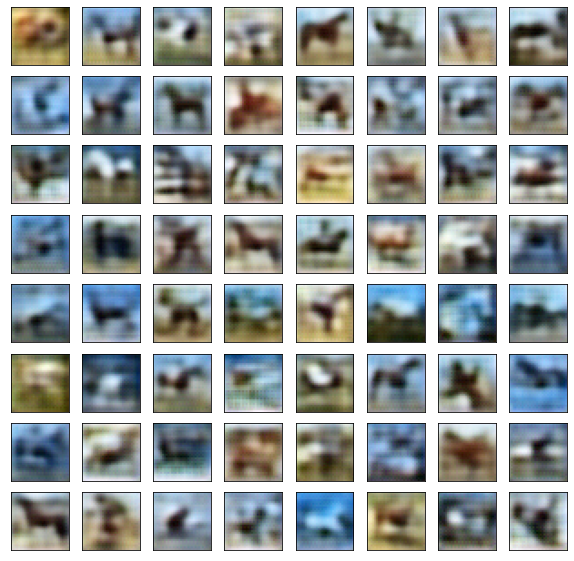

In [14]:
Interpolate()